In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.nn.functional as F
from blinky import Blinky
from finetune_utils import get_peft_model, merge_peft_model, Config
from datasets import load_dataset
from processor import BlinkyProcessor

In [2]:
config = Config(
    embed_dim = 576,
    intermediate_dim = 1536,
    max_position_embeddings = 8192,
    base_theta = 100000,
    num_q_heads = 9,
    num_kv_heads = 3,
    attn_dropout = 0.,
    num_layers = 30,
    vocab_size = 49152,
    dtype = torch.bfloat16,
    eos_token_id = 2,
    image_start_token_id = 49152,
    image_end_token_id = 49153,
    image_token_id = 49154,
    num_image_tokens=256,
    prefix_length=1+256+1 #<|start_of_image|>256*<|image_token|><|end_of_image|>
)

In [3]:
model = Blinky(config)

In [4]:
model._prepare_for_training()

new_embedding_weight torch.Size([49155, 576])


In [5]:
def verify_trainable_params():
    for n,p in model.named_parameters():
        if p.requires_grad:
            print(n)

# verify_trainable_params()

In [6]:
dataset = load_dataset('openbmb/RLAIF-V-Dataset')['train']

In [7]:
origins = pd.DataFrame({'origin': dataset['origin_dataset']})

In [8]:
train_idxs, valid_idxs = train_test_split(origins, stratify=origins['origin'], test_size=0.03, random_state=2025)
len(train_idxs), len(valid_idxs)

(80638, 2494)

In [9]:
train_dataset = dataset.select(train_idxs.index)
valid_dataset = dataset.select(valid_idxs.index)

In [10]:
train_dataset

Dataset({
    features: ['ds_name', 'image', 'question', 'chosen', 'rejected', 'origin_dataset', 'origin_split', 'idx', 'image_path'],
    num_rows: 80638
})

In [11]:
def make_conversation(samples):
    conversations = []
    for q,a in zip(samples['question'], samples['chosen']):
        conversations.append([
            {'role': 'user', 'content': q},
            {'role': 'assistant', 'content': a}
        ])
    samples['text'] = conversations
    return samples

In [12]:
train_dataset = train_dataset.select(np.arange(10_000))
train_dataset = train_dataset.map(make_conversation,batched=True,num_proc=8,batch_size=512)

In [13]:
train_dataset = train_dataset.remove_columns(
    ['ds_name', 'question', 'chosen', 'rejected', 'origin_dataset', 'origin_split', 'idx', 'image_path']
)

In [14]:
processor = BlinkyProcessor('./Blinky')

In [15]:
def collate_fn(samples):
    inputs = processor(samples)
    labels = inputs['input_ids'].clone()
    # shift
    labels[:,:-1] = labels[:,1:]
    for ignore_token in [49154,49152,49153]:
        mask = (labels==ignore_token).long()
        labels[mask==1] = -100
        
    padding_mask = (inputs['input_ids']==processor.tokenizer.pad_token_id).long()
    labels[padding_mask==1] = -100
    inputs['labels'] = labels
    return inputs

In [16]:
model = model.cuda()

In [23]:
dataloader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size = 2,
    shuffle = True,
    collate_fn = collate_fn,
    num_workers = 1,
)

In [30]:
from PIL import Image

In [34]:
sample = [{
    'text': [{'role':'user','content':'what do you see in this image?'}],
    'image': Image.open('./tests/cat.jpg')
}]
processor.apply_chat_template([s['text'] for s in sample])

['<|start_of_image|><|image_token|><|image_token|><|image_token|><|image_token|><|image_token|><|image_token|><|image_token|><|image_token|><|image_token|><|image_token|><|image_token|><|image_token|><|image_token|><|image_token|><|image_token|><|image_token|><|image_token|><|image_token|><|image_token|><|image_token|><|image_token|><|image_token|><|image_token|><|image_token|><|image_token|><|image_token|><|image_token|><|image_token|><|image_token|><|image_token|><|image_token|><|image_token|><|image_token|><|image_token|><|image_token|><|image_token|><|image_token|><|image_token|><|image_token|><|image_token|><|image_token|><|image_token|><|image_token|><|image_token|><|image_token|><|image_token|><|image_token|><|image_token|><|image_token|><|image_token|><|image_token|><|image_token|><|image_token|><|image_token|><|image_token|><|image_token|><|image_token|><|image_token|><|image_token|><|image_token|><|image_token|><|image_token|><|image_token|><|image_token|><|image_token|><|ima

In [24]:
sample = next(iter(dataloader))

In [25]:
sample

{'input_ids': tensor([[49152, 49154, 49154, 49154, 49154, 49154, 49154, 49154, 49154, 49154,
          49154, 49154, 49154, 49154, 49154, 49154, 49154, 49154, 49154, 49154,
          49154, 49154, 49154, 49154, 49154, 49154, 49154, 49154, 49154, 49154,
          49154, 49154, 49154, 49154, 49154, 49154, 49154, 49154, 49154, 49154,
          49154, 49154, 49154, 49154, 49154, 49154, 49154, 49154, 49154, 49154,
          49154, 49154, 49154, 49154, 49154, 49154, 49154, 49154, 49154, 49154,
          49154, 49154, 49154, 49154, 49154, 49154, 49154, 49154, 49154, 49154,
          49154, 49154, 49154, 49154, 49154, 49154, 49154, 49154, 49154, 49154,
          49154, 49154, 49154, 49154, 49154, 49154, 49154, 49154, 49154, 49154,
          49154, 49154, 49154, 49154, 49154, 49154, 49154, 49154, 49154, 49154,
          49154, 49154, 49154, 49154, 49154, 49154, 49154, 49154, 49154, 49154,
          49154, 49154, 49154, 49154, 49154, 49154, 49154, 49154, 49154, 49154,
          49154, 49154, 491

In [18]:
def get_optimizer(model, vision_lr=1e-5, vision_proj_lr=1e-3, text_lr=1.5e-5):
    
    for p in model.parameters():
        p.requires_grad = False
    
    vision_params = []
    vision_proj_params = []
    text_params = []
    
    for p in model.vision_model.vision.parameters():
        p.requires_grad = True
        vision_params.append(p)
            
    for p in model.vision_model.rms_norm.parameters():
        p.requires_grad = True
        vision_proj_params.append(p)
                
    for p in model.vision_model.dim_proj.parameters():
        p.requires_grad = True
        vision_proj_params.append(p)
    
    for n,p in model.text_model.named_parameters():
        if 'embed_tokens' in n or 'lm_head' in n:
            continue
        else:
            p.requires_grad = True
            text_params.append(p)
    
    param_groups = [
        {'params': vision_params, 'lr': vision_lr},
        {'params': vision_proj_params, 'lr': vision_proj_lr},
        {'params': text_params, 'lr': text_lr},
    ]
    
    optimizer = torch.optim.AdamW(param_groups, weight_decay=0.1)
    
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    total_params = sum(p.numel() for p in model.parameters())
    print(f"Trainable parameters: {trainable_params:,} ({trainable_params/total_params:.2%} of total)")
    
    return optimizer

In [19]:
optim = get_optimizer(model)
sched = torch.optim.lr_scheduler.OneCycleLR(
    optim,
    max_lr=[pg['lr'] for pg in optim.param_groups],
    total_steps=len(dataloader),
    pct_start=0.1
)

Trainable parameters: 200,166,720 (87.61% of total)


In [20]:
losses = []
log_steps = 500
total_loss = 0
for batch_idx, batch in tqdm(enumerate(dataloader), total=len(dataloader)):
    batch = {k:v.cuda() for k,v in batch.items()}
    loss = model(**batch)
    loss.backward()
    optim.step()
    sched.step()
    optim.zero_grad()
    total_loss += loss.item()
    if (batch_idx+1) % log_steps == 0 or batch_idx==len(dataloader)-1:
        print(f"step={batch_idx} {loss.item():.3f}")
        losses.append(total_loss / log_steps)
        total_loss = 0.

  0%|          | 0/1250 [00:00<?, ?it/s]

step=499 2.125
step=999 2.234
step=1249 1.852


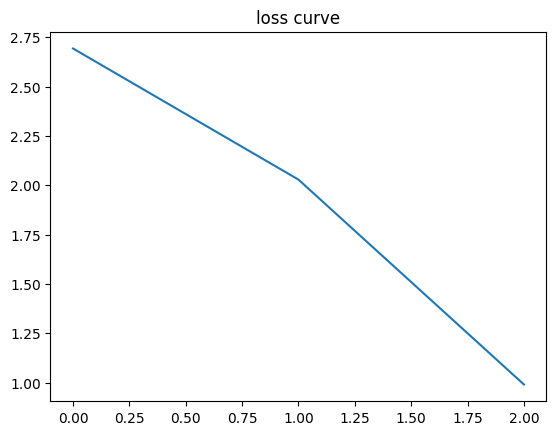

In [21]:
fig=plt.figure()
plt.plot(losses)
plt.title('loss curve')
fig.savefig('losses.png')

In [ ]:
sd = merged_model.state_dict()
torch.save(sd,'./Blinky/model.pt')